# Homework 2: Second J&S Model
## Travis Hammond - s2880024

First, let's import everything from the previous homework.

In [1]:
from pathlib import Path
from typing import List

import sys; sys.path.append(Path().resolve().parent.as_posix())  # noqa

from ACTR.model import Model
from ACTR.dmchunk import Chunk
from ACTR.plot import plot

import pandas as pd
import numpy as np
from scipy.stats import truncexpon


rng = np.random.default_rng(seed=111)


def noise(
            s: float
        ) -> float:
    rand = rng.uniform(0.001, 0.999)
    return s * np.log((1 - rand) / rand)


def time_to_pulses(
            time: float,
            t_0: float = 0.011,
            a: float = 1.1,
            b: float = 0.015
        ) -> int:
    pulses = 0
    pulse_duration = t_0
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses += 1
        pulse_duration = a * pulse_duration + noise(b * a * pulse_duration)
    return pulses


def pulses_to_time(
            pulses: int,
            t_0: float = 0.011,
            a: float = 1.1,
            b: float = 0.015
        ) -> float:
    time = 0
    pulse_duration = t_0
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + noise(b * a * pulse_duration)
    return time


def init_model(
            id: int
        ) -> Model:
    """We create a (model of a) participant here.

    This gives us a way to initialize them with some prior knowledge if
    necessary, and give them a unique id.

    Args:
        id (int): The unique id of the participant.

    Returns:
        Model: A fresh subject to experiment on.
    """
    subj = Model()
    subj.id = id
    return subj

The only change here is in the do_trial function, where we do a blended trace retrieval instead of a regular Chunk retrieval. This returns a value and a latency, as opposed to a Chunk and a latency as before, so we don't access a slot but instead directly pass the blended value to the pulses_to_time function. We also don't have to reinforce the memory because that is handled in the retrieve_blended_trace function.

In [2]:
def do_trial(
            subj: Model,
            sample_interval: float
        ) -> float:
    """This function takes a subject and an interval time, and goes through
    the process of an experiment trial.

    Args:
        subj (Model): The subject which will do the trial.
        sample_interval (float): The interval time defining the trial.

    Returns:
        float: The (re)production time.
    """
    # "Trials began with the presentation of a central fixation point for 1s,"
    subj.time += 1
    # "followed by the presentation of a warning stimulus ..."
    # "After a variable delay ranging from 0.25-0.85s drawn randomly from a
    # truncated exponential distribution, ..."
    subj.time += truncexpon(0.6, 0.25).rvs(1, random_state=rng)[0]
    # "two 100ms flashes separated by the sample interval were presented."
    subj.time += 0.1  # READY
    subj.time += sample_interval

    # convert time to pulses and remember how many it took
    pulses = time_to_pulses(sample_interval)
    subj.add_encounter(Chunk(
        name=f'pf_{pulses}',
        slots={'isa': 'pulse-fact', 'pulses': pulses}
    ))

    # "Production times, t_p, were measured from the center of the flash, (that
    # is, 50ms after its onset) to when the key was pressed"
    subj.time += 0.05  # SET

    # retrieve a blended trace
    request = Chunk(
        name='pulse-request',
        slots={'isa': 'pulse-fact'}
    )
    value, latency = subj.retrieve_blended_trace(request, 'pulses')
    subj.time += latency

    # convert pulse to time, then add and return the production time
    production_time = pulses_to_time(value)
    subj.time += production_time  # GO
    return production_time

Everything else stays the same:

In [3]:
def do_experiment(
            participants: List[Model],
            n_test_trials: int,
            n_train_trials: int
        ) -> pd.DataFrame:
    """Perform the experiment on a list of participants.

    Args:
        participants (list(Model)): The volunteering participants.
        n_test_trials (int): The number of testing trials.
        n_train_trials (int): The number of training trials.

    Returns:
        pandas.DataFrame: The collected data as a pandas DataFrame.
    """

    # "All priors were discrete uniform distributions with 11 values, ranging
    # from 494–847 ms for the short, 671–1,023 ms for the intermediate and
    # 847–1,200 ms for long prior condition."
    prior_distributions = np.array([
        (1, np.linspace(start=0.494, stop=0.847, num=11)),
        (2, np.linspace(start=0.671, stop=1.023, num=11)),
        (3, np.linspace(start=0.847, stop=1.200, num=11)),
    ], dtype='object')

    # create the DataFrame
    row_idx = 0
    data = pd.DataFrame(columns=[
        'Subj', 'Cond', 'line', 'Trial', 'Ts', 'Tp', 'MaxTrial', 'Main'
    ])

    # each subject goes through the experiment
    for subj in participants:

        # "For each subject, the order in which the three prior conditions were
        # tested was randomized."
        rng.shuffle(prior_distributions)
        for condition, distribution in prior_distributions:

            # "For each prior condition, subjects were tested after they
            # completed an initial learning stage." (here: train, then test)
            for trial_idx in range(1, n_train_trials + n_test_trials + 1):

                # "sample intervals are drawn randomly from one of three
                # partially overlapping discrete uniform prior distributions."
                sample_interval = rng.choice(distribution)

                # perform the actual trial
                production_time = do_trial(subj, sample_interval)
                # don't give feedback

                # record the results just like the authors did
                data.loc[row_idx] = [
                    subj.id + 1,
                    condition,
                    row_idx + 1,
                    trial_idx,
                    # the plotting code expects (ms) units for some reason
                    # else the jitter is all over the place
                    sample_interval * 1000,
                    production_time * 1000,
                    n_train_trials + n_test_trials,
                    False if trial_idx <= n_train_trials else True
                ]
                row_idx += 1

            # reset declarative memory by re-initializing the subject
            subj = init_model(subj.id)

    return data

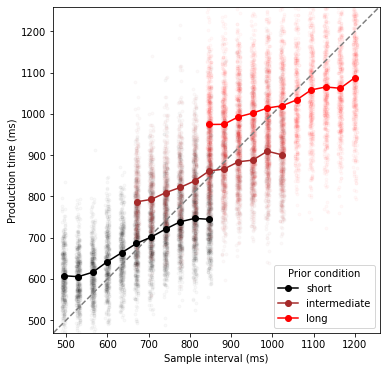

In [4]:
def main(
            n_participants: int = 5,
            n_train_trials: int = 500,
            n_test_trials: int = 1000
        ) -> None:
    # create the participants, do the experiment and record the data. then, plot
    participants = [init_model(sid) for sid in range(n_participants)]
    simulated_data = do_experiment(participants, n_test_trials, n_train_trials)
    plot(simulated_data)


if __name__ == '__main__':
    main()

The data now looks like a better fit than the straight lines in last weeks homework, but there are still some large differences. Firstly, we can see that, because of the blending, the production times for sample intervals at both extremes of the prior condition (or in other words, the sample intervals that are the farthest away from the interval mean) are biased towards the mean of the production times (essentially it is a weighted average based on activation, and the mean is increasingly weighted more). This results in this sigmoidal tendency/shape which is more prominent the shorter the condition.

Secondly, it seems like it does not exhibit the scalar property with all conditions seemingly showing the same slope/slant towards the identity line (although it is hard to tell by eyeballing). It could be that the sigmoidal tendency (the amount of bias towards the mean) is how the scalar property is expressed in our model, which would indicate that our model is not completely correct.